## Road Marking Monitoring for Smart Cities
    
### Alexander Jung$^{1,2}$, Jyoti Prasad Bartaula$^{1}$, Sangam Deuja$^{1}$
$^{1}$Integrify ry, Helsinki, Finland
<br><br>
$^{2}$Department of Computer Science, Aalto University, Finland 
</center>

**Abstract**—We study machine learning methods for monitoring
the condition of road markings in the city of Helsinki.
The monitoring is based on the open geoinformation service
https://kartta.hel.fi. This service provides building maps as
well as orthophotos which are collected on a regular basis.
The resulting methods and datasets are made available
openly under https://github.com/alexjungaalto/ResearchPublic/tree/master/RoadMarkingHelsinki.

#### <center>Introduction</center>
Road markings are an important component of the
infrastructure in modern cities. Carefully planned road markings
allow for traffic management and urban planning. In order to fully 
utilize the desired effect of road markings, it is important
to continuously monitor their condition in order to schedule road 
maintenance early on. 

Having accurate
information about the current status of road markings is also
instrumental for driver assistance and autonomous driving
systems. <br>
This paper surveys different methods from machine learning
that allow to monitor the condition of road markings in the
city region of Helsinki. These methods are fed with data that is
available via the open map service https://kartta.hel.fi. Beside
aerial photographs, this service also provides
access to city planning information such as building maps 
and plans of road infrastructure. These different types of 
information constitute various layers that can be superimposed 
for a particular geographical area. 

<br>
<figure>
    <img src="out.jpg" alt='missing' width='300'/>
    <br>
    <figcaption style="text-align:center;">Fig. 1. Aerial photograph of a region within the Helsinki city area.</figcaption>
</figure>

<a id='LoadDataset'></a>
<div class=" alert alert-info">
    <b>Demo.</b>  
  
<p>
The code snippet below imports all required packages (libraries) and established a connected to the geoinformation server kartta.hel.fi.
</p>

</div>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import datetime
import numpy as np
import cv2
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from owslib.wms import WebMapService
from skimage.feature import hog
import io

wms = WebMapService('https://kartta.hel.fi/ws/geoserver/avoindata/wms', version='1.1.1')


# define the bounding box of the entire city area 

xmin = 24.92
ymin = 60.15
xmax = 24.99
ymax = 60.20

# we divide the entire city area evenly into nr_patches_x x nr_patches_y square patches 

nr_patches_x = 50 
nr_patches_y = 50 

patch_x = (xmax-xmin)/nr_patches_x  # width of an individual patch
patch_y = (ymax-ymin)/nr_patches_y  # height of a single patch 

<a id='LoadDataset'></a>
<div class=" alert alert-info">
    <b>Demo.</b>  
  
<p>
The code snippet below reads in the information about one particular patch of the Helsinki city area. It then depicts an aerial photograph and the building map for this patch. 
</p>

</div>

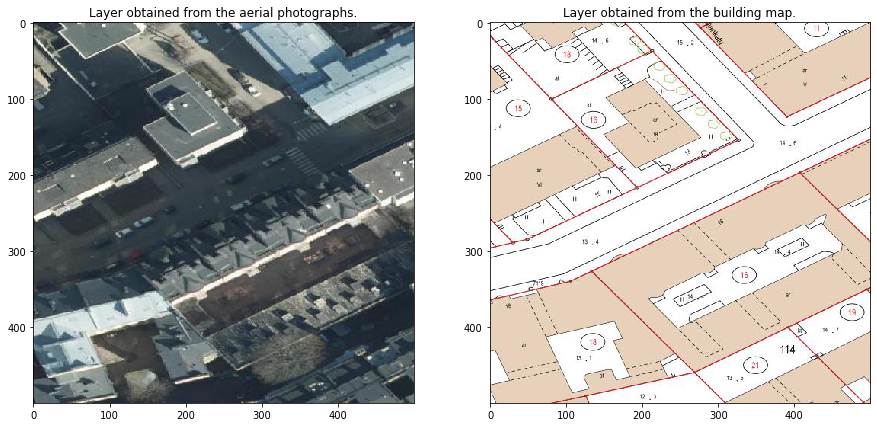

In [2]:
# choose one particular patch 

nr_x = 11 
nr_y = 10

# determine the bounding box for this particular patch 

patch_box = (xmin+nr_x*patch_x,ymin+nr_y*patch_y,xmin+(nr_x+1)*patch_x,ymin+(nr_y+1)*patch_y) 

ortholayer = 'avoindata:Ortoilmakuva_2019_5cm' # choose layer with aerial photographs 
cs = 'EPSG:4326'
resx=500    # choose number of pixels in one direction 
res = (resx,resx)

fig, axes = plt.subplots(1, 2, figsize=(15, 15))

img = wms.getmap(layers=[ortholayer],srs=cs,bbox=patch_box,size=res,format='image/jpeg',transparent=True)
A_1 = np.asarray(Image.open(io.BytesIO(img.read())))
axes[0].imshow(A_1)
axes[0].set_title("Layer obtained from the aerial photographs.") 


img = wms.getmap(layers=['Karttasarja'],srs=cs,bbox=patch_box,size=res,format='image/jpeg',transparent=True)
A_1_layer_1 = np.asarray(Image.open(io.BytesIO(img.read())))
axes[1].imshow(A_1_layer_1)
axes[1].set_title("Layer obtained from the building map.") 

plt.show()

#### <center>PROBLEM FORMULATION</center>
Our goal is to study different methods which allow to automatically locate existing road markings in Helsinki city area. The efficient localization of existing road markings is an enabling first step towards monitoring their condition. 

We formulate this localization problem as a pixel
labelling problem. Each pixel of a multi-layer map represents a particular location within the city area. We consider those pixels as data points which are classified as $y = 1$
if the pixel depicts a road marking and $y = −1$ if the pixel
does not depict a road marking. Any pixel is characterized by a feature vector $\mathbf{x}=\big(x_{1},\ldots,x_{n}\big)^{T} \in \mathbb{R}^{n}$ whose entries are obtained from the different layers available at <https://kartta.hel.fi>.

Another approach is based on using the available information
about existing road markings and apply unsupervised
learning methods to learn to distinguish between regions with
road markings and those without any road marking.

#### <center>SUPERVISED METHODS</center>
 
We have divided the depicted region evenly into $50 \times 50$ square patches $\mathcal{P}^{(i,j)}$, for $i,j \in \{1,\ldots,50\}$. Each patch represents a certain part of the Helsinki city area. Figure 1 depicts the patch $\mathcal{P}^{(11,10)}$ obtained for $i=11$ and $j=10$. 
For the particular patch $\mathcal{P}^{(11,10)}$, we manually label pixels which depict road markings in 
the patch $\mathcal{P}^{(11,10)}$. We indicate the pixels which have been labelled as depicting a pedestrian 
crossing by red circles in Figure 4 and denote their total number by $m$. 

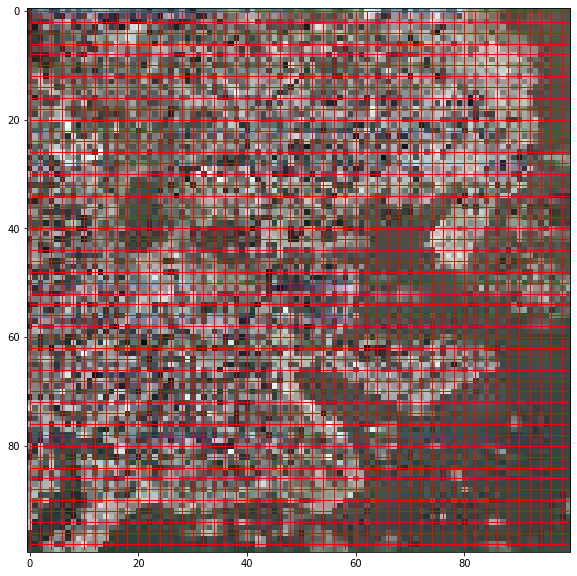

In [3]:
import math

ortholayer = 'avoindata:Ortoilmakuva_2019_5cm'
cs = 'EPSG:4326'
layer='avoindata:Ortoilmakuva_2019_5cm'
resx=100
res = (resx,resx)
patch_box = (xmin,ymin,xmax,ymax) 
img = wms.getmap(layers=[ortholayer],srs=cs,bbox=patch_box,size=res,format='image/jpeg',transparent=True)
pic = Image.open(io.BytesIO(img.read()))
plt.figure(figsize=(10,10))
plt.imshow(np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3))
delta_x = math.floor(resx/nr_patches_x) ; 
delta_y = math.floor(resx/nr_patches_y) ; 

for x in range(nr_patches_x):
     plt.plot([0,resx-1],[x*delta_x,x*delta_x],'-',color='red',linewidth=1)
        
for y in range(nr_patches_y):
     plt.plot([y*delta_y,y*delta_y],[0,resx-1],'-',color='red',linewidth=1)
 
plt.show() 

<a id='LoadDataset'></a>
<div class=" alert alert-info">
    <b>Demo.</b>  
  
<p>
The code snippet below reads in the labeled road marking pixels for the particular patch $\mathcal{P}^{(11,10)}$ from a csv file. 
</p>

</div>

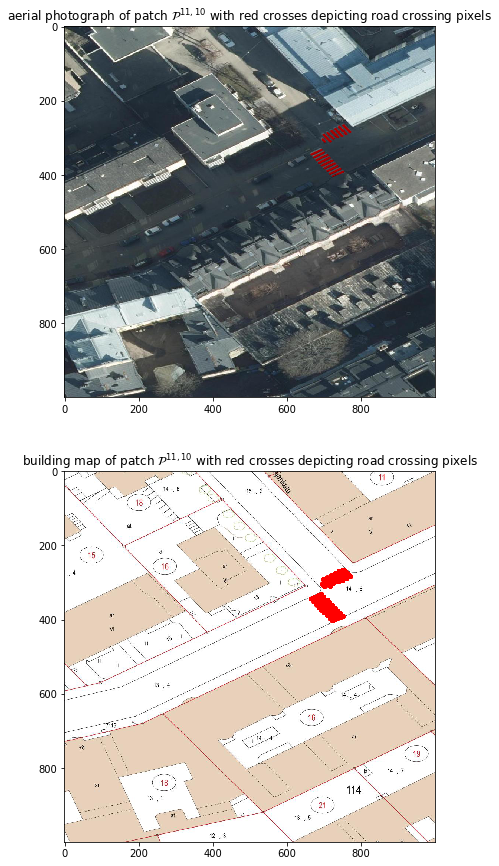

In [56]:

# choose particular patch of Helsinki city area 
nr_x = 11 
nr_y = 10
patch_box = (xmin+nr_x*patch_x,ymin+nr_y*patch_y,xmin+(nr_x+1)*patch_x,ymin+(nr_y+1)*patch_y) 
resx_labels = 4000 

filename = 'PixelLabels_patchx_{:03d}_patchy_{:03d}_res_{:03d}.csv'.format(nr_x,nr_y,resx_labels) 
df=pd.read_csv(filename, sep=',') # read in coords of road marking pixels in patch 



ortholayer = 'avoindata:Ortoilmakuva_2019_5cm'  # choose aerial photograph layer 
cs = 'EPSG:4326'       # choose coordinate system
resx=1000              # resolution in number of pixels per each dimension 
res = (resx,resx)      # use same resolution for x and y axis

img = wms.getmap(layers=[ortholayer],srs=cs,bbox=patch_box,size=res,format='image/jpeg',transparent=True)

fig, axs = plt.subplots(2, 1, figsize=(15, 15))
A_1 = np.asarray(Image.open(io.BytesIO(img.read())))
axs[0].imshow(A_1)
axs[0].scatter(df['cols'].values/4, df['rows'].values/4,s=1/10000, c='r', marker='.')
axs[0].set_title("aerial photograph of patch $\mathcal{P}^{11,10}$ with red crosses depicting road crossing pixels")

img = wms.getmap(layers=['Karttasarja'],srs=cs,bbox=patch_box,size=res,format='image/jpeg',transparent=True)
#filename = 'Helsinki_patchx_{:03d}_patchy_{:03d}_resolution_{:03d}.jpg'.format(nr_x,nr_y,resx) 
#out = open(filename, 'wb')
#out.write(img.read())
#out.close()
A_1_layer_1 = np.asarray(Image.open(io.BytesIO(img.read())))
#A_1 = mpimg.imread(filename)
#plt.imshow(mpimg.imread('out.jpg'))
axs[1].imshow(A_1_layer_1)
#fig.axes.get_xaxis().set_visible(False)
#fig.axes.get_yaxis().set_visible(False)
axs[1].scatter(df['cols'].values/4, df['rows'].values/4,s=6, c='r', marker='.')
axs[1].set_title("building map of patch $\mathcal{P}^{11,10}$ with red crosses depicting road crossing pixels")
plt.show()



In order to predict the label $y$ for a particular pixel we use the red, green and blue components of 
that pixel as feature vector
\begin{equation} 
\mathbf{x} = \big( \mbox{red}, \mbox{green}, \mbox{blue} \big)^{T}.
\end{equation} 
We then train a linear classifier $h^{(\mathbf{w})} = \mathbf{w}^{T} \mathbf{x}$ 
using logistic regression on a training set which is obtained by randomly selecting 
$m_{\rm train} \approx (67/100) \times m $ labelled pixels. The remaining labelled pixels 
are used as the test (validation) set. 

We evaluate the performance of the classifier 
\begin{equation} 
\hat{y} ={\rm sign}  \big\{ \mathbf{w}^{T} \mathbf{x} \big \} = \begin{cases} 1 & \mbox{ for } \mathbf{w}^{T}\mathbf{x} > 0 \\ 
-1 & \mbox{ otherwise}\end{cases}
\end{equation}
on the test set which results in the following confusion matrix 
<table>
    <tr>
        <th></th>
        <th>$y\!=\!1$  (road marking)</th>
        <th>$y\!=\!-1$  (no road marking)</th>
    </tr>
    <tr>
        <th>$\hat{y}=1$</th>
        <td>$0.99$</td>
        <td>$0.08$</td>
    </tr>
    <tr>
        <th>$\hat{y}=-1$</th>
        <td>$0.01$</td>
        <td>$0.92$</td>
    </tr>
</table>


<a id='TrainClassifier'></a>
<div class=" alert alert-info">
    <b>Demo.</b>  
  
<p>
The code snippet below trains a classifier via minimizing the logistic loss on the training set which is obtained by randomly selecting a subset of labeled pixels (which are known to either show road marking or not). 
</p>

</div>

342.5


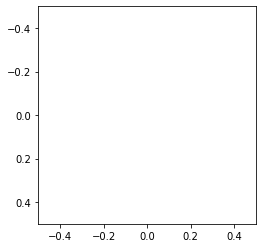

train accurarcy = 0.9422885572139303
test accurarcy = 0.9151515151515152
[148 221 375 436]


/Users/alexanderjung/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/alexanderjung/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


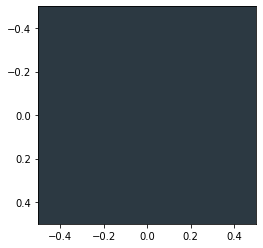

0.9771428571428571


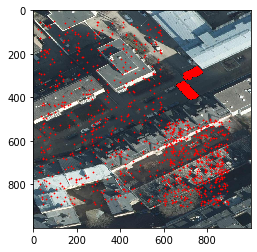

In [57]:
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

#pixelx = df['cols'][100]
#pixely = df['rows'][100]

nr_x = 11
nr_y = 10

rows = df['rows'].values/4
cols = df['cols'].values/4

rows_crossing = rows.astype(int)
cols_crossing = cols.astype(int)

print(rows[3])

len_x = 0 
len_y = 0

nr_features = 2*3*(2*len_x+1)*(2*len_y+1)  # 2 layers (orthophot +karrta) times 3 colors times nr of pixels

number_road_markings = rows.shape[0]

nr_samples = 500 # rows.shape[0]
permutation = np.random.randint(0,number_road_markings-1, size=nr_samples)
X = np.zeros((nr_samples,nr_features))

# features and labels of patches whose center pixel is road marking 

for idx_sample in range(nr_samples):
     pixelx = cols_crossing[permutation[idx_sample]]
     pixely = rows_crossing[permutation[idx_sample]]
     B = A_1[(pixely-len_y):(pixely+len_y+1),(pixelx-len_x):(pixelx+len_x+1)]
     tmp = B.reshape(1,-1)
    
     B = A_1_layer_1[(pixely-len_y):(pixely+len_y+1),(pixelx-len_x):(pixelx+len_x+1)]
     tmp_1 = B.reshape(1,-1)
    
     X[idx_sample,:] = np.hstack((tmp,tmp_1)); 
        
y= np.ones((nr_samples,1))

plt.imshow(B) 
#print(B)
plt.show()



# features and labels of patches whose center pixel is not road marking 
nr_non_marking_samples = 1000

rows = np.random.randint(50,900, size=int(nr_non_marking_samples/2))
cols = np.random.randint(20,600,size=int(nr_non_marking_samples/2))

rows_tmp = np.random.randint(500,900, size=int(nr_non_marking_samples/2))
cols_tmp = np.random.randint(600,900,size=int(nr_non_marking_samples/2))
rows = np.append(rows,rows_tmp)
cols = np.append(cols,cols_tmp)

X_tmp = np.zeros((nr_non_marking_samples,nr_features))
for iter_sample in range(nr_non_marking_samples):
        pixelx = cols[iter_sample] 
        pixely = rows[iter_sample]
        B =  A_1[(pixely-len_y):(pixely+len_y+1),(pixelx-len_x):(pixelx+len_x+1)]
        tmp = B.reshape(1,-1)
        B = A_1_layer_1[(pixely-len_y):(pixely+len_y+1),(pixelx-len_x):(pixelx+len_x+1)]
        tmp_1 = B.reshape(1,-1)
        X_tmp[iter_sample,:] = np.hstack((tmp,tmp_1)); 

X = np.vstack((X,X_tmp))


y = np.vstack((y,-np.ones((nr_non_marking_samples,1))))    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
 

#mlp = MLPClassifier(hidden_layer_sizes=(1000,), max_iter=1000, alpha=1e-4,
 #                   solver='sgd', verbose=10, random_state=1,
  #                  learning_rate_init=.1)


clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#mlp.fit(X_train, y_train)

print("train accurarcy =", clf.score(X_train, y_train))
print("test accurarcy =", clf.score(X_test, y_test))

y_pred_test = clf.predict(X_test).reshape((-1,1))

tmp = y_pred_test*(-1)+y_test  ## entries are 2 only if true label is 1 (road marking) but predicted label is -1

samples_missed = np.where(tmp> 1) 
samples_missed= samples_missed[0]
if samples_missed.shape[0]>0 : 
    print(samples_missed)
    C = X_test[samples_missed[0],:int(nr_features/2)]
    C = (C.reshape((2*len_y+1,2*len_x+1,3)))
    plt.imshow(C/255) 
    plt.show()
else: 
    print("No crossing missed!")


result = np.where( (abs(y_test-1)<0.1) & (abs(y_pred_test-1)<0.1))
roadpixels = np.where(abs(y_test-1)<0.1) 
noroadpixels = np.where(abs(y_test+1)<0.1) 
roadpixels = roadpixels[0]
noroadpixels= noroadpixels[0]
result = result[0]
missed_rate = result.shape[0]/roadpixels.shape[0]

# stack row,col coords of crossing pixels with non-crossing pixels 

rows_all = np.append(rows_crossing,rows)
cols_all = np.append(cols_crossing,cols)


print(missed_rate)

plt.imshow(A_1)

plt.scatter(cols_all, rows_all,s=0.6, c='r', marker='x')
#plt.scatter(cols_crossing,rows_crossing,marker='o')
plt.show()



#### <center>UNSUPERVISED METHODS</center>
The geographic information service https://kartta.hel.fi provides a list for the locations of documented 
pedestrian crossings (see Figure 5).
<br>
<br>
<figure>
    <img src="SnapshotPedestrianCrossing.jpg" alt='missing' width='300'/>
    <br>
    <figcaption style="text-align:center;">Fig. 5. Aerial photograph of a small region (patch) within Helsinki city area. The red circles indicate 
	pixels belonging to a pedestrian crossing.</figcaption>
</figure>
<br>
<br>
We have obtained the bounding boxes for $m$ 
regions that should depict road markings. The resulting $m$ images are represented by their feature 
vectors $\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)}$.<br>
<figure>
    <img src="1.PNG" alt='missing' width='300'/>
    <figcaption style="text-align:center;">Fig. 6. Four regions that have been documented at https://kartta.hel.fi as including a pedestrian crossing.</figcaption>
</figure>
<br>

Each feature vector $\mathbf{x}^{(i)}$ contains the red, green and blue components of all pixels that 
constitute the $i$-th image. In order to find anomalous pedestrian crossings we have first applied 
dimensionality reduction via t-SNE \cite{tSNEPaper} yielding the new feature vectors $\mathbf{z}^{(i)} \in \mathbb{R}^{2}$ of length two. We then applied the clustering method DBSCAN \cite{DBSCAN} to organize the set of all images into few clusters. The resulting clustering results in one dominant cluster which contains the majority 
of images. We declare the images not belonging to the dominant cluster as anomalous images. 
<figure>
    <img src="ClusteredImages.jpg" alt='missing' width='300'/>
    <br>
    <figcaption style="text-align:center;">Fig. 7. Scatter plot of pedestrian crossing images. The images are represented
by the t-SNE vectors $\mathbf{z}^{(i)} \in \mathbb{R}^{2}$. Anomalous images are represented with
crosses “×”.</figcaption>
</figure>

Figure 7 depicts the resulting partitioning of the images into regular and 
anomalous images. Each anomalous image $i$ is represented by a cross $\times$ located at the 
coordinates given by the t-SNE vector $\mathbf{z}^{(i)}$. The other (non-anomalous) images are 
represented by a circle $o$. Some examples of images which are declared as anomalous are shown 
in Figure 8.

<figure>
    <img src="2.PNG" alt='missing' width='300'/>
    <figcaption style="text-align:center;">Fig. 8. Images of pedestrian crossings that have been declared as anomalous.</figcaption>
</figure>


**References**

B. Mathibela, P. Newman and I. Posner, "Reading the Road: Road Marking Classification and Interpretation," in IEEE Transactions on Intelligent Transportation Systems, vol. 16, no. 4, pp. 2072-2081, Aug. 2015.
doi: 10.1109/TITS.2015.2393715
URL: http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7055289&isnumber=7174612

H. Jin and Y. Feng, "Automated road pavement marking detection from high resolution aerial images based on multi-resolution image analysis and anisotropic Gaussian filtering," 2010 2nd International Conference on Signal Processing Systems, Dalian, 2010, pp. V1-337-V1-341.
doi: 10.1109/ICSPS.2010.5555636 URL: http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5555636&isnumber=5555236

S. M. Azimi, P. Fischer, M. Körner and P. Reinartz, "Aerial LaneNet: Lane-Marking Semantic Segmentation in Aerial Imagery Using Wavelet-Enhanced Cost-Sensitive Symmetric Fully Convolutional Neural Networks," in IEEE Transactions on Geoscience and Remote Sensing, vol. 57, no. 5, pp. 2920-2938, May 2019.
doi: 10.1109/TGRS.2018.2878510
URL: http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8556373&isnumber=8697166